In [1]:
!pip install -e .

Obtaining file:///C:/Users/shive/OneDrive/Desktop/Sem%205/CS698/CS698-Deep-Reinforcement-Learning/assignment_1
  Attempting uninstall: assignment-1
    Found existing installation: assignment-1 0.0.1
    Uninstalling assignment-1-0.0.1:
      Successfully uninstalled assignment-1-0.0.1
  Running setup.py develop for assignment-1


In [2]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Problem 1: Multi-armed Bandits

In [6]:
genv = gym.make('assignment_1.envs:gaussianBandit-v0', size = 10)
benv = gym.make('assignment_1.envs:bernoulliBandit-v0', alpha = 0.5, beta = 0.5)

In [54]:
def testBernoulliBandit(N=10**5):
  tests = [ [0.5, 0.5], [1,0], [0,1], [0,0], [1,1] ]
  for i,test in enumerate(tests):
    print("Test:",i, test)
    benv = gym.make('assignment_1.envs:bernoulliBandit-v0', alpha = test[0], beta = test[1])
    ralpha = 0 ; rbeta = 0
    for j in range(N):
        _, r, _, _ = benv.step(0)
        ralpha += r
        _, r, _, _ = benv.step(1)
        rbeta += r
    print((test[0]*N - ralpha)/N)
    print((test[1]*N - rbeta)/N)

testBernoulliBandit(N=10**6)

Test: 0 [0.5, 0.5]
0.000308
0.000698
Test: 1 [1, 0]
0.0
0.0
Test: 2 [0, 1]
0.0
0.0
Test: 3 [0, 0]
0.0
0.0
Test: 4 [1, 1]
0.0
0.0


In [ ]:
def testGaussianBandit():
    tests = []

In [32]:
def pureGreedy(env,maxEpisodes):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    a = np.random.choice(np.flatnonzero(np.isclose(Q, np.max(Q))))
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

def pureExplore(env, maxEpisodes):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    a = np.random.randint(env.action_space.n)
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

def epsGreedy(env,maxEpisodes,eps):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    if np.random.rand(1) < eps:
      a = np.random.randint(env.action_space.n)
    else:
      a = np.random.choice(np.flatnonzero(np.isclose(Q, np.max(Q))))
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

def decEpsGreedy(env,maxEpisodes,eps_start, eps_end, decayType='exponential'):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    if decayType == 'linear':
      eps = eps_start + i*(eps_end-eps_start)/(maxEpisodes-1)
    else:
      eps = eps_start*((eps_end/eps_start)**(i/(maxEpisodes-1)))

    if np.random.rand(1) < eps:
      a = np.random.randint(env.action_space.n)
    else:
      a = np.random.choice(np.flatnonzero(np.isclose(Q, np.max(Q))))
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

def UCB(env, maxEpisodes, c):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    if i < env.action_space.n:
      a = i
    else:
      U = c*np.sqrt(np.log(i+1)/N)
      a = np.random.choice(np.flatnonzero(np.isclose(Q+U, np.max(Q+U))))
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

def softMax(env, maxEpisodes, temp_start, temp_end):
  '''
  '''
  Q = np.zeros(env.action_space.n)
  N = np.zeros(env.action_space.n)
  Q_est = np.zeros((maxEpisodes,env.action_space.n))
  rewards = []
  actions = []

  for i in range(maxEpisodes):
    temp = temp_start + i*(temp_end-temp_start)/(maxEpisodes-1)

    probs = np.exp(Q/temp)/np.sum(np.exp(Q/temp))
    a = np.random.choice(a=env.action_space.n, p=probs)
    s, r, terminal, info = env.step(a)
    rewards.append(r)
    actions.append(a)
    N[a] += 1
    Q[a] += (r-Q[a])/N[a]
    Q_est[i] = Q

  return Q_est, rewards, actions

100it [00:24,  4.15it/s]


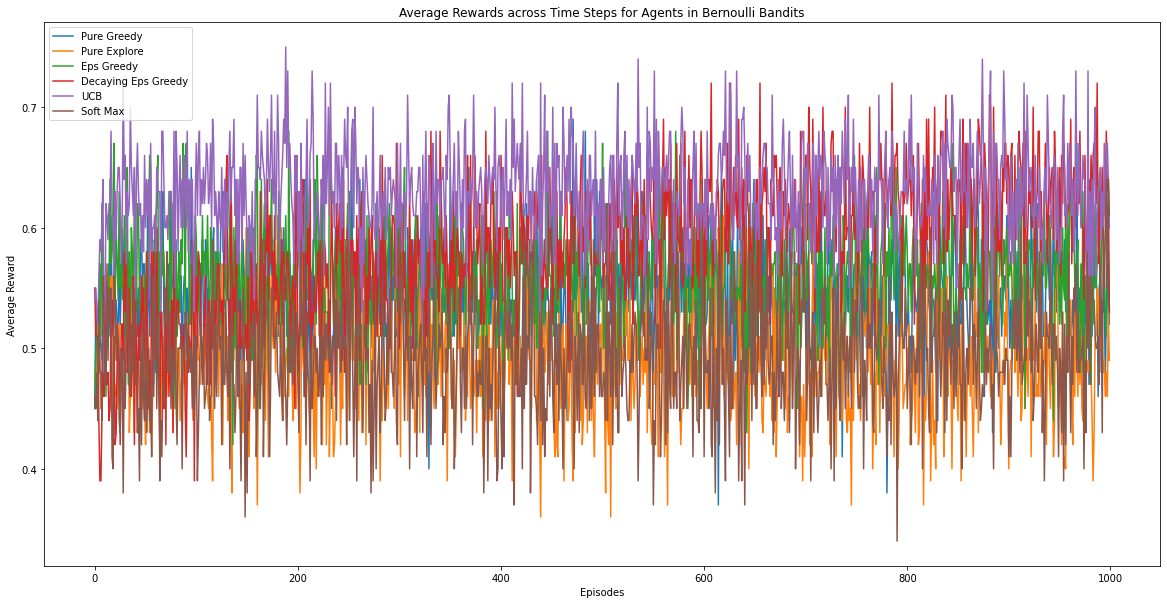

In [63]:
def AvgRewardsNBernoulliBandits(N=50, episodes = 10**3):
    tests = []
    for i in range(N):
        tests.append(list(np.random.uniform(size=2)))

    pureGreedy_R = []
    pureExplore_R = []
    epsGreedy_R = []
    decEpsGreedy_R = []
    UCB_R = []
    softMax_R = []

    for i,test in tqdm(enumerate(tests)):
        benv = gym.make('assignment_1.envs:bernoulliBandit-v0', alpha = test[0], beta = test[1])
        _,rs,_ = pureGreedy(env=benv, maxEpisodes = episodes)
        pureGreedy_R.append(rs)
        _,rs,_ = pureExplore(env=benv, maxEpisodes=episodes)
        pureExplore_R.append(rs)
        _,rs,_ = epsGreedy(env=benv, maxEpisodes=episodes, eps=0.5)
        epsGreedy_R.append(rs)
        _,rs,_ = decEpsGreedy(env=benv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        decEpsGreedy_R.append(rs)
        _,rs,_ = UCB(env=benv, maxEpisodes=episodes, c=0.2)
        UCB_R.append(rs)
        _,rs,_ = softMax(env=benv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        softMax_R.append(rs)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Average Rewards across Time Steps for Agents in Bernoulli Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward') 
    plt.plot(np.arange(episodes), np.mean(pureGreedy_R,axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), np.mean(pureExplore_R,axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), np.mean(epsGreedy_R,axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(decEpsGreedy_R,axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(UCB_R,axis=0), label='UCB')
    plt.plot(np.arange(episodes), np.mean(softMax_R,axis=0), label='Soft Max')
    plt.legend()
    plt.show()       
    
AvgRewardsNBernoulliBandits(N=10**2, episodes=10**3)

100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


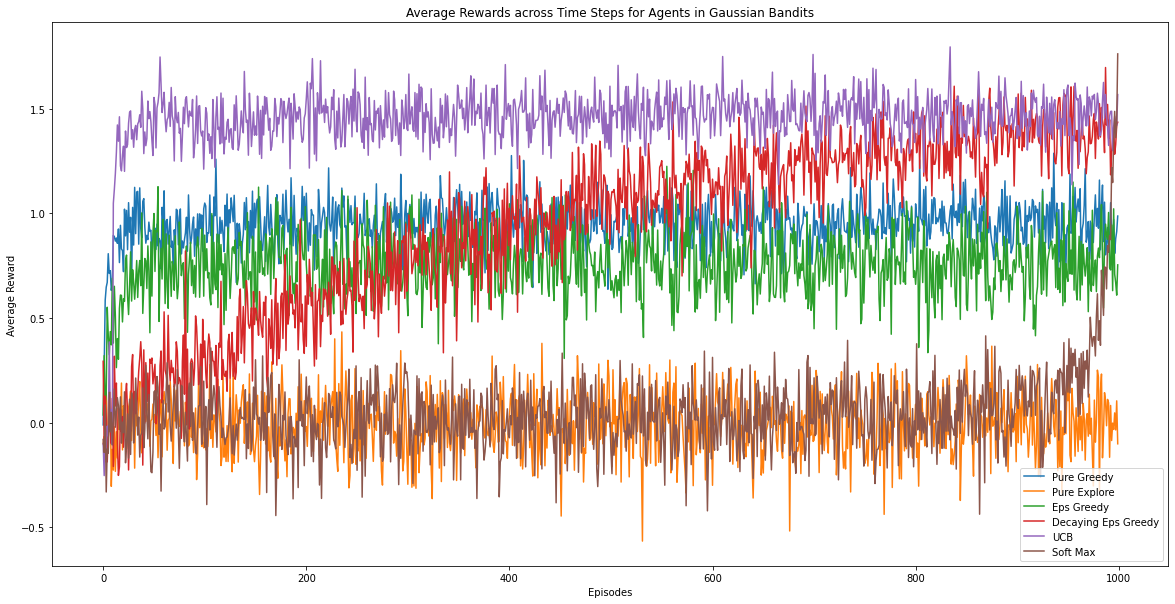

In [64]:
def AvgRewardsNGaussianBandits(N=50, episodes=10**3):
    pureGreedy_R = []
    pureExplore_R = []
    epsGreedy_R = []
    decEpsGreedy_R = []
    UCB_R = []
    softMax_R = []

    for i in tqdm(range(N)):
        genv = gym.make('assignment_1.envs:gaussianBandit-v0', size = 10)
        _,rs,_ = pureGreedy(env=genv, maxEpisodes = episodes)
        pureGreedy_R.append(rs)
        _,rs,_ = pureExplore(env=genv, maxEpisodes=episodes)
        pureExplore_R.append(rs)
        _,rs,_ = epsGreedy(env=genv, maxEpisodes=episodes, eps=0.5)
        epsGreedy_R.append(rs)
        _,rs,_ = decEpsGreedy(env=genv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        decEpsGreedy_R.append(rs)
        _,rs,_ = UCB(env=genv, maxEpisodes=episodes, c=0.2)
        UCB_R.append(rs)
        _,rs,_ = softMax(env=genv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        softMax_R.append(rs)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Average Rewards across Time Steps for Agents in Gaussian Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward') 
    plt.plot(np.arange(episodes), np.mean(pureGreedy_R,axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), np.mean(pureExplore_R,axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), np.mean(epsGreedy_R,axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(decEpsGreedy_R,axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(UCB_R,axis=0), label='UCB')
    plt.plot(np.arange(episodes), np.mean(softMax_R,axis=0), label='Soft Max')
    plt.legend()
    plt.show()  

AvgRewardsNGaussianBandits(N=10**2, episodes=10**3) 

50it [00:18,  2.67it/s]


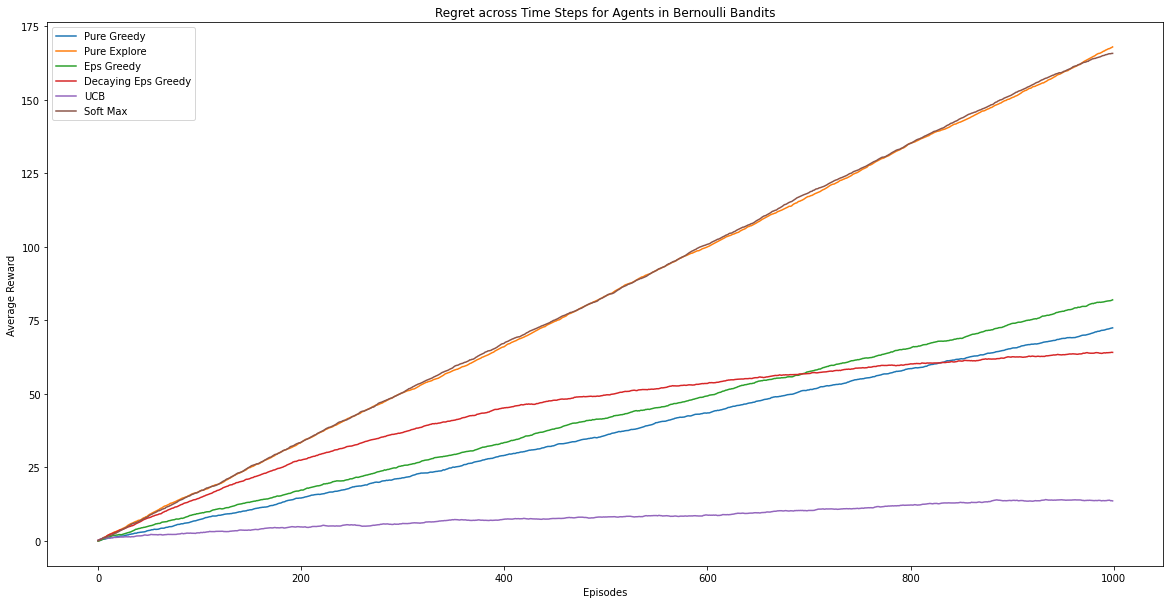

In [95]:
def RegretNBernoulliBandits(N=50, episodes = 10**3):
    tests = []
    for i in range(N):
        tests.append(list(np.random.uniform(size=2)))

    pureGreedy_R = []
    pureExplore_R = []
    epsGreedy_R = []
    decEpsGreedy_R = []
    UCB_R = []
    softMax_R = []

    for i,test in tqdm(enumerate(tests)):
        benv = gym.make('assignment_1.envs:bernoulliBandit-v0', alpha = test[0], beta = test[1])
        optimalReward = max(test[0],test[1])
        optimalTrajectory = np.ones(episodes)*optimalReward
        _,rs,_ = pureGreedy(env=benv, maxEpisodes = episodes)
        pureGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = pureExplore(env=benv, maxEpisodes=episodes)
        pureExplore_R.append(optimalTrajectory-rs)
        _,rs,_ = epsGreedy(env=benv, maxEpisodes=episodes, eps=0.5)
        epsGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = decEpsGreedy(env=benv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        decEpsGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = UCB(env=benv, maxEpisodes=episodes, c=0.2)
        UCB_R.append(optimalTrajectory-rs)
        _,rs,_ = softMax(env=benv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        softMax_R.append(optimalTrajectory-rs)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Regret across Time Steps for Agents in Bernoulli Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Regret') 
    plt.plot(np.arange(episodes), np.mean(np.cumsum(pureGreedy_R,axis=1),axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(pureExplore_R,axis=1),axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(epsGreedy_R,axis=1),axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(decEpsGreedy_R,axis=1),axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(UCB_R,axis=1),axis=0), label='UCB')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(softMax_R,axis=1),axis=0), label='Soft Max')
    plt.legend()
    plt.show()       
    
RegretNBernoulliBandits(N=50, episodes=10**3)

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


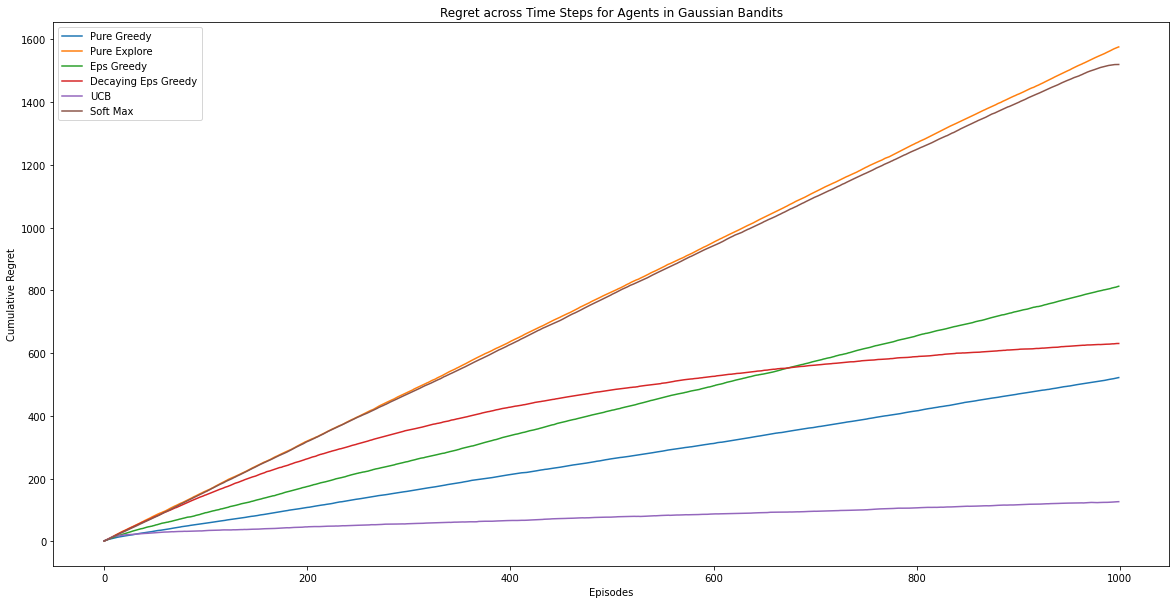

In [98]:
def RegretNGaussianBandits(N=50, episodes=10**3):
    pureGreedy_R = []
    pureExplore_R = []
    epsGreedy_R = []
    decEpsGreedy_R = []
    UCB_R = []
    softMax_R = []

    for i in tqdm(range(N)):
        genv = gym.make('assignment_1.envs:gaussianBandit-v0', size = 10)
        optimalReward = max(genv.rewards)
        optimalTrajectory = np.ones(episodes)*optimalReward
        _,rs,_ = pureGreedy(env=genv, maxEpisodes = episodes)
        pureGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = pureExplore(env=genv, maxEpisodes=episodes)
        pureExplore_R.append(optimalTrajectory-rs)
        _,rs,_ = epsGreedy(env=genv, maxEpisodes=episodes, eps=0.5)
        epsGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = decEpsGreedy(env=genv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        decEpsGreedy_R.append(optimalTrajectory-rs)
        _,rs,_ = UCB(env=genv, maxEpisodes=episodes, c=0.2)
        UCB_R.append(optimalTrajectory-rs)
        _,rs,_ = softMax(env=genv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        softMax_R.append(optimalTrajectory-rs)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Regret across Time Steps for Agents in Gaussian Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Regret') 
    plt.plot(np.arange(episodes), np.mean(np.cumsum(pureGreedy_R,axis=1),axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(pureExplore_R,axis=1),axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(epsGreedy_R,axis=1),axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(decEpsGreedy_R,axis=1),axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(UCB_R,axis=1),axis=0), label='UCB')
    plt.plot(np.arange(episodes), np.mean(np.cumsum(softMax_R,axis=1),axis=0), label='Soft Max')
    plt.legend()
    plt.show() 

RegretNGaussianBandits(N=50, episodes=10**3) 

50it [00:11,  4.20it/s]


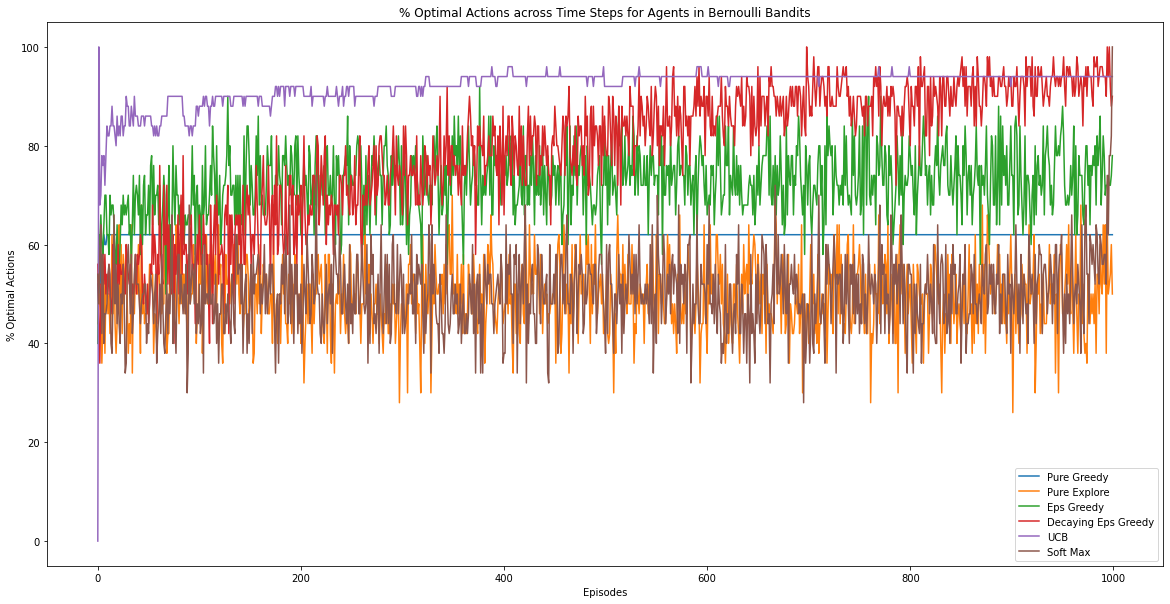

In [65]:
def OptimalActionNBernoulliBandits(N=50, episodes=10**3):
    tests = []
    for i in range(N):
        #by making the max element always index 1, we can simply take mean of actions to find percentage optimal action 
        test = np.random.uniform(size=2)
        tests.append([min(test), max(test)])

    pureGreedy_a = []
    pureExplore_a = []
    epsGreedy_a = []
    decEpsGreedy_a = []
    UCB_a = []
    softMax_a = []

    for i,test in tqdm(enumerate(tests)):
        benv = gym.make('assignment_1.envs:bernoulliBandit-v0', alpha = test[0], beta = test[1])
        _,_,a_ = pureGreedy(env=benv, maxEpisodes = episodes)
        pureGreedy_a.append(a_)
        _,_,a_ = pureExplore(env=benv, maxEpisodes=episodes)
        pureExplore_a.append(a_)
        _,_,a_ = epsGreedy(env=benv, maxEpisodes=episodes, eps=0.5)
        epsGreedy_a.append(a_)
        _,_,a_ = decEpsGreedy(env=benv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        decEpsGreedy_a.append(a_)
        _,_,a_ = UCB(env=benv, maxEpisodes=episodes, c=0.2)
        UCB_a.append(a_)
        _,_,a_ = softMax(env=benv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        softMax_a.append(a_)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("% Optimal Actions across Time Steps for Agents in Bernoulli Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('% Optimal Actions') 
    plt.plot(np.arange(episodes), 100*np.mean(pureGreedy_a,axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(pureExplore_a,axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), 100*np.mean(epsGreedy_a,axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(decEpsGreedy_a,axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(UCB_a,axis=0), label='UCB')
    plt.plot(np.arange(episodes), 100*np.mean(softMax_a,axis=0), label='Soft Max')
    plt.legend()
    plt.show()  

OptimalActionNBernoulliBandits(N=50, episodes=10**3)

100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


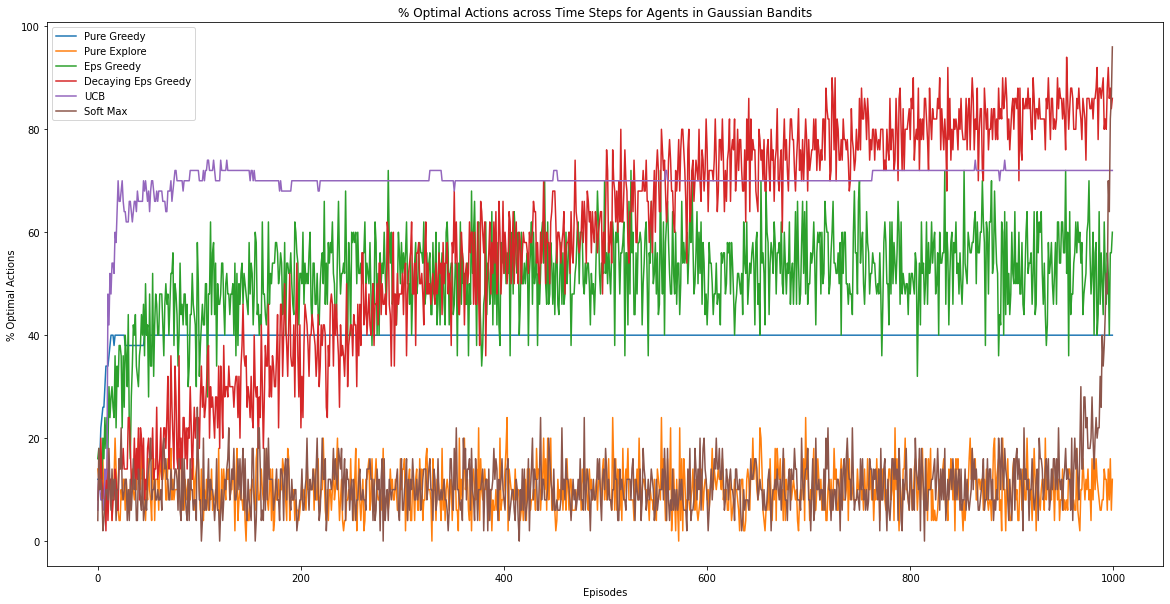

In [71]:
def OptimalActionNGaussianBandits(N=50, episodes=10**3):
    pureGreedy_a = []
    pureExplore_a = []
    epsGreedy_a = []
    decEpsGreedy_a = []
    UCB_a = []
    softMax_a = []

    for i in tqdm(range(N)):
        genv = gym.make('assignment_1.envs:gaussianBandit-v0', size = 10)
        optimalAction = np.argmax(genv.rewards)
        _,_,a_ = pureGreedy(env=genv, maxEpisodes = episodes)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        pureGreedy_a.append(a_)
        _,_,a_ = pureExplore(env=genv, maxEpisodes=episodes)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        pureExplore_a.append(a_)
        _,_,a_ = epsGreedy(env=genv, maxEpisodes=episodes, eps=0.5)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        epsGreedy_a.append(a_)
        _,_,a_ = decEpsGreedy(env=genv, maxEpisodes=episodes, eps_start=1, eps_end=0.1)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        decEpsGreedy_a.append(a_)
        _,_,a_ = UCB(env=genv, maxEpisodes=episodes, c=0.2)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        UCB_a.append(a_)
        _,_,a_ = softMax(env=genv, maxEpisodes=episodes, temp_start=10**2, temp_end=0.01)
        for j in range(len(a_)):
            if a_[j] == optimalAction:
                a_[j] = 1
            else:
                a_[j] = 0
        softMax_a.append(a_)
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("% Optimal Actions across Time Steps for Agents in Gaussian Bandits")
    plt.xlabel('Episodes')
    plt.ylabel('% Optimal Actions') 
    plt.plot(np.arange(episodes), 100*np.mean(pureGreedy_a,axis=0), label='Pure Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(pureExplore_a,axis=0), label='Pure Explore')
    plt.plot(np.arange(episodes), 100*np.mean(epsGreedy_a,axis=0), label='Eps Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(decEpsGreedy_a,axis=0), label='Decaying Eps Greedy')
    plt.plot(np.arange(episodes), 100*np.mean(UCB_a,axis=0), label='UCB')
    plt.plot(np.arange(episodes), 100*np.mean(softMax_a,axis=0), label='Soft Max')
    plt.legend()
    plt.show() 

OptimalActionNGaussianBandits(N=50, episodes=10**3)

# Problem 2: Monte Carlo Estimates and TD Learning

In [82]:
rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)

In [83]:
def testRWE(N=10**2):
    tests = [[7,0.5], [10,1], [3,1]]
    for i,test in enumerate(tests):
        print("Test:",i, test)
        rwe = gym.make('assignment_1.envs:RWE-v0', n_states = test[0], prob=test[1])
        for j in range(N):
            s, r, terminal, _ = rwe.step(1)
            print("Step:",j,"State:",s,"Reward:",r)
            if terminal:
                break
testRWE(N=10**2)       

Test: 0 [7, 0.5]
Step: 0 State: 2 Reward: 0
Step: 1 State: 3 Reward: 0
Step: 2 State: 2 Reward: 0
Step: 3 State: 1 Reward: 0
Step: 4 State: 2 Reward: 0
Step: 5 State: 1 Reward: 0
Step: 6 State: 2 Reward: 0
Step: 7 State: 3 Reward: 0
Step: 8 State: 4 Reward: 0
Step: 9 State: 5 Reward: 0
Step: 10 State: 6 Reward: 1
Test: 1 [10, 1]
Step: 0 State: 6 Reward: 0
Step: 1 State: 7 Reward: 0
Step: 2 State: 8 Reward: 0
Step: 3 State: 9 Reward: 1
Test: 2 [3, 1]
Step: 0 State: 2 Reward: 1


In [84]:
def generateTrajectory(env, pi, maxSteps):
  '''
  env: gym env
  pi: 2d array mapping from state to actions to their probabilities
    pi[state] = [p_back, p_front]
  maxSteps: int
  '''
  trajectory = []
  env.reset()
  for i in range(maxSteps):
    s = env.state
    a = np.random.choice(a=len(pi[s]),p=pi[s])
    s_, r, terminal, _ = env.step(a)
    trajectory.append((s,a,r,s_))
    if terminal is True:
      return trajectory
  return []

In [87]:
def testGenerateTrajectory():
    pi = [
      [0,0],
      [0.1,0.9],
      [0.2,0.8],
      [0.3,0.7],
      [0.4,0.6],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=1)
    T = generateTrajectory(env=rwe, pi=pi, maxSteps=10**2)
    for t, (s,a,r,s_) in enumerate(T):
      print("Step:",t)
      print("State:",s,"Action:",a,"Reward:",r,"Next State:",s_)

testGenerateTrajectory()

Step: 0
State: 3 Action: 1 Reward: 0 Next State: 4
Step: 1
State: 4 Action: 1 Reward: 0 Next State: 5
Step: 2
State: 5 Action: 0 Reward: 0 Next State: 4
Step: 3
State: 4 Action: 1 Reward: 0 Next State: 5
Step: 4
State: 5 Action: 1 Reward: 1 Next State: 6


In [88]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType='exponential'):
  '''
  initialValue: float
  finalValue: float
  maxSteps: int
  decayType: string
  '''
  alphas = []
  for i in range(maxSteps):
    if decayType == 'linear':
      alpha = initialValue + i*(finalValue-initialValue)/(maxSteps-1)
    if decayType == 'exponential':
      alpha = initialValue*((finalValue/initialValue)**(i/(maxSteps-1)))
    alphas.append(alpha)
  return alphas

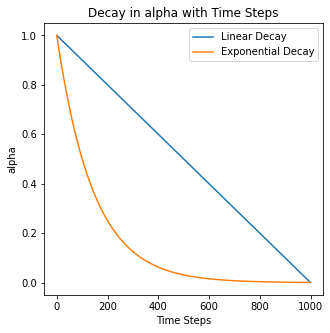

In [89]:
def testDecayAlpha(initialValue=1, finalValue=10**-3, maxSteps=10**3):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.title("Decay in alpha with Time Steps")  
    plt.xlabel('Time Steps')
    plt.ylabel('alpha')  
    plt.plot(np.arange(maxSteps),decayAlpha(initialValue,finalValue,maxSteps,'linear'), label='Linear Decay')
    plt.plot(np.arange(maxSteps),decayAlpha(initialValue,finalValue,maxSteps,'exponential'), label='Exponential Decay')
    plt.legend()
    plt.show()

testDecayAlpha()

In [167]:
def monteCarloPrediction(env, pi, gamma, alpha_start, alpha_end, maxSteps, maxEpisodes, firstVisit, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxSteps: int
  maxEpisodes: int
  firstVisit: boolean
    toggle FVMC/EVMC updates
  '''
  v = np.zeros(env.n_states)
  v_r = np.zeros((maxEpisodes, env.n_states))
  g = np.zeros((maxEpisodes,env.n_states))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)

  for e in range(maxEpisodes):
    t = generateTrajectory(env, pi, maxSteps)
    visited = np.zeros(env.n_states)

    for i, (s,a,r,s_) in enumerate(t):
      if visited[s] and firstVisit:
        continue

      G = 0
      for j in range(len(t)):
        G += gamma**(j-i)*t[j][2]
      g[e][s] = G
      v[s] += alphas[e]*(G-v[s])

    v_r[e] = v 
  return v_r,g

In [168]:
def testMonteCarloPrediction():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    vrs_true = [0.0, 0.2, 0.4, 0.6, 0.8]
    print("True Estimates:", vrs_true)
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing FVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.2, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=5*10**3, firstVisit=True, decayType='exponential')
    print("FVMC Estimates: ",vrs[-1][1:-1])
    print("Error:", np.abs(((vrs[-1][1:-1]-vrs_true))))
    rwe.reset()
    print("Testing EVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.2, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=5*10**3, firstVisit=False, decayType='exponential')
    print("EVMC Estimates:",vrs[-1][1:-1])
    print("Error:", np.abs((vrs[-1][1:-1]-vrs_true)))

testMonteCarloPrediction()

True Estimates: [0.0, 0.2, 0.4, 0.6, 0.8]
Testing FVMC
FVMC Estimates:  [2.92646921e-05 7.26306968e-04 6.00297168e-03 6.29028278e-02
 5.61109616e-01]
Error: [2.92646921e-05 1.99273693e-01 3.93997028e-01 5.37097172e-01
 2.38890384e-01]
Testing EVMC
EVMC Estimates: [6.60513173e-05 7.87438711e-04 7.18339151e-03 6.74012127e-02
 5.79506579e-01]
Error: [6.60513173e-05 1.99212561e-01 3.92816608e-01 5.32598787e-01
 2.20493421e-01]


In [169]:
def temporalDifferencePrediction(env, pi, gamma, alpha_start, alpha_end, maxEpisodes, decayType='exponential'):
  '''
  env: gym env
  pi: 
  gamma: float
  alpha: float
  maxEpisodes: int
  '''
  v = np.zeros(env.n_states)
  v_r = np.zeros((maxEpisodes, env.n_states))
  g = np.zeros((maxEpisodes,env.n_states))
  alphas = decayAlpha(alpha_start, alpha_end, maxEpisodes, decayType)
  for e in range(maxEpisodes):
    env.reset()
    s = env.state
    terminal = False

    while not terminal:
      a = np.random.choice(a=len(pi[s]),p=pi[s])
      # a = np.argmax(pi[s])
      s_, r, terminal, _ = env.step(a)
      # print(a,s,s_)
      td_target = r

      if not terminal:
        td_target += gamma*v[s_]

      g[e][s] = td_target
      td_error = td_target - v[s]
      v[s] += alphas[e]*td_error
      s = s_
    v_r[e] = v
  return v_r,g

In [170]:
def testTemporalDifferencePrediction():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    vrs_true = [0.0, 0.2, 0.4, 0.6, 0.8]
    print("True Estimates:", vrs_true)
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing TD")
    vrs,_ = temporalDifferencePrediction(env=rwe, pi=pi, gamma=0.2, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**3, decayType='exponential')
    print("TD Estimates: ",vrs[-1][1:-1])
    print("Error:", np.abs(((vrs[-1][1:-1]-vrs_true))))

testTemporalDifferencePrediction()

True Estimates: [0.0, 0.2, 0.4, 0.6, 0.8]
Testing TD
TD Estimates:  [6.60157032e-05 6.35057921e-04 5.50742886e-03 5.05953864e-02
 4.69675318e-01]
Error: [6.60157032e-05 1.99364942e-01 3.94492571e-01 5.49404614e-01
 3.30324682e-01]


Testing EVMC
EVMC Estimates: [0.03303449 0.07958124 0.18521228 0.37053151 0.70727217]


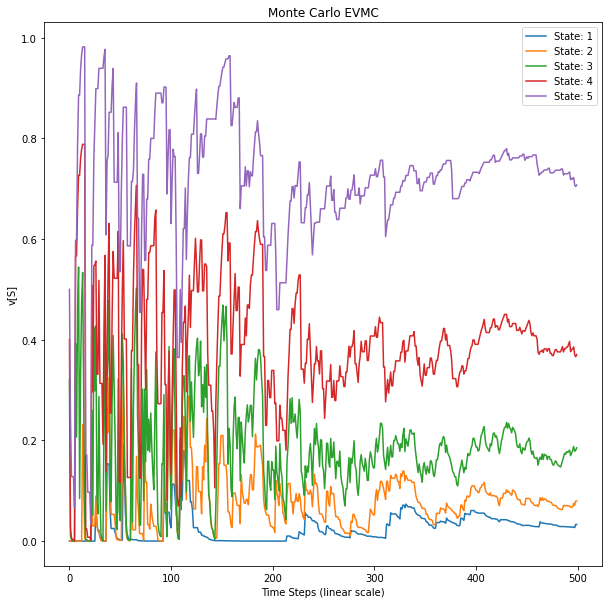

In [171]:
def MCEVMCLinear():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing EVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    print("EVMC Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.arange(500), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCEVMCLinear()

Testing FVMC
FVMC Estimates: [0.01938367 0.05421104 0.16018858 0.34033924 0.63690664]


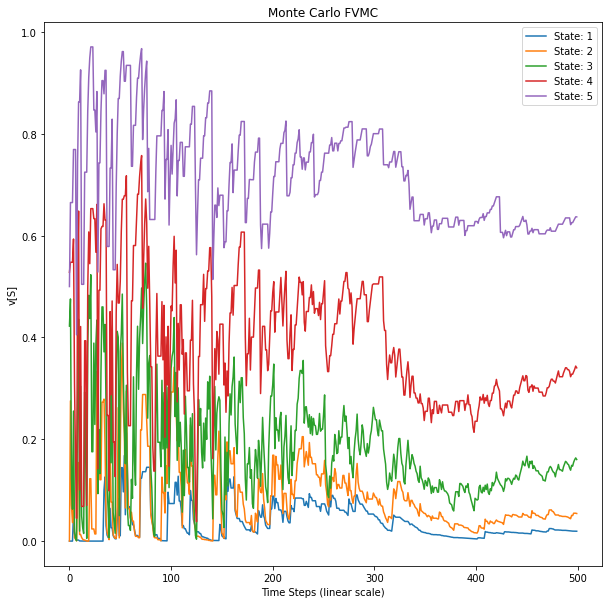

In [172]:
def MCFVMCLinear():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing FVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=True, decayType='exponential')
    print("FVMC Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.arange(500), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCFVMCLinear()

Testing TD
TD Estimates: [0.06978182 0.15347958 0.26499377 0.43501223 0.66716615]


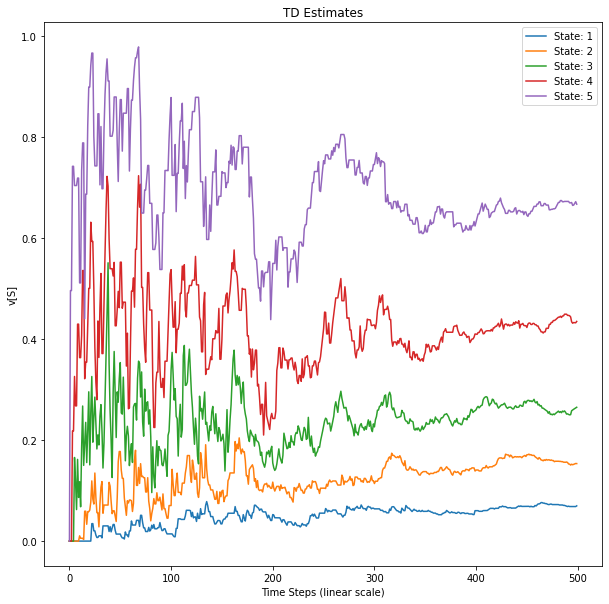

In [173]:
def TDLinear():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing TD")
    vrs,_ = temporalDifferencePrediction(env=rwe, pi=pi, gamma=0.9, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Estimates")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.arange(500), vrs[:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLinear()

Testing EVMC
EVMC Estimates: [0.04458162 0.11694593 0.2200927  0.41971998 0.71645095]


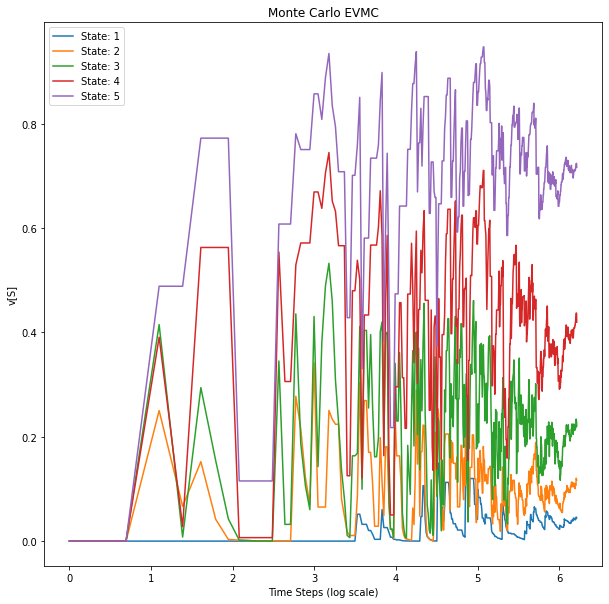

In [174]:
def MCEVMCLog():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing EVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    print("EVMC Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC")  
    plt.xlabel('Time Steps (log scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.log(np.arange(1,500)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCEVMCLog()

Testing FVMC
FVMC Estimates: [0.03182087 0.10974317 0.22347901 0.39530406 0.7542014 ]


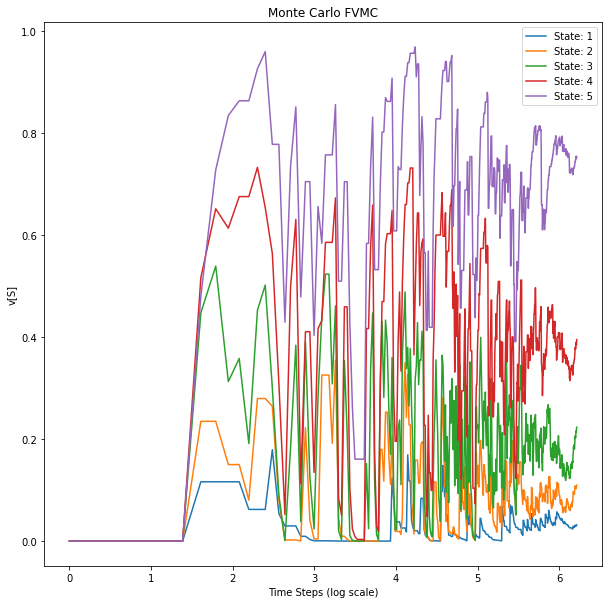

In [175]:
def MCFVMCLog():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing FVMC")
    vrs,_ = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=True, decayType='exponential')
    print("FVMC Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC")  
    plt.xlabel('Time Steps (log scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.log(np.arange(1,500)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

MCFVMCLog()

Testing TD
TD Estimates: [0.06516799 0.13930961 0.25732105 0.42978147 0.68258238]


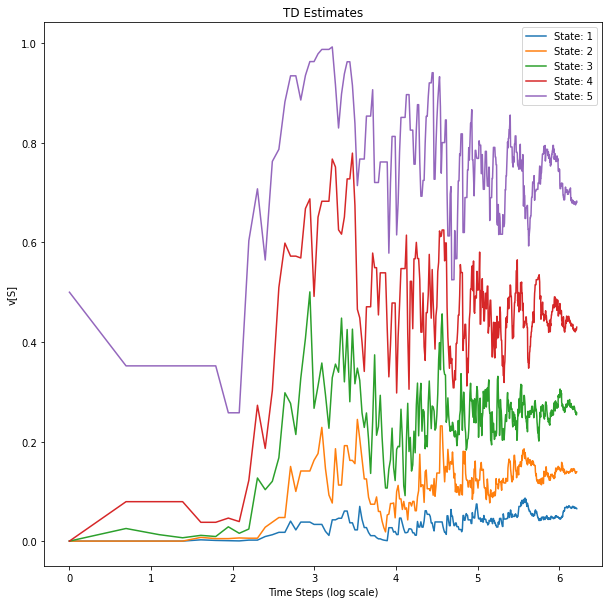

In [176]:
def TDLog():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing TD")
    vrs,_ = temporalDifferencePrediction(env=rwe, pi=pi, gamma=0.9, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    print("TD Estimates:",vrs[-1][1:-1])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD Estimates")  
    plt.xlabel('Time Steps (log scale)')
    plt.ylabel('v[S]')
    for i in range(1,rwe.n_states-1):
        plt.plot(np.log(np.arange(1,500)), vrs[1:,i], label=('State: '+str(i)))
    plt.legend()
    plt.show()

TDLog()

Testing FVMC


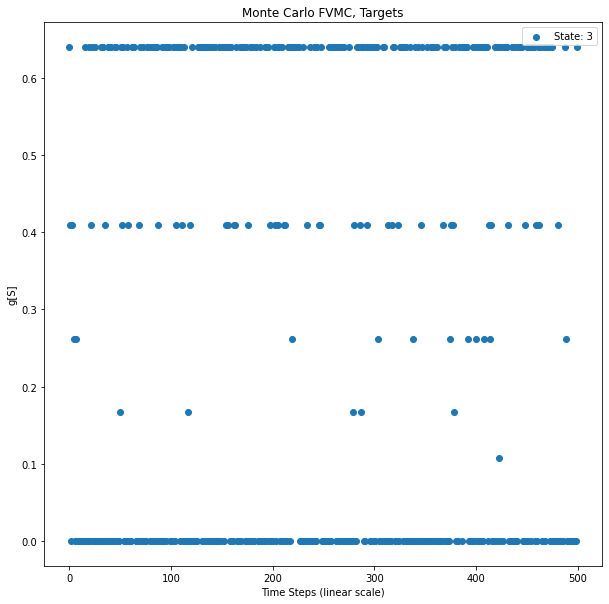

In [179]:
def targetFVMC():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing FVMC")
    _,g = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=True, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo FVMC, Targets")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,3], label=('State: 3'))
    plt.legend()
    plt.show()

targetFVMC()

Testing EVMC


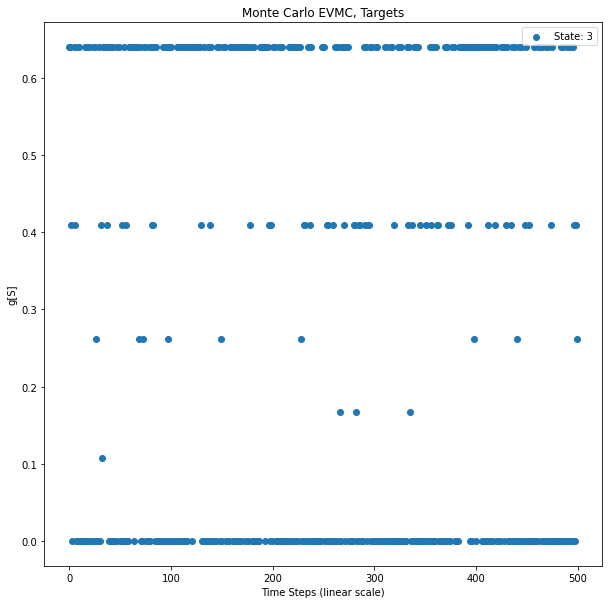

In [180]:
def targetEVMC():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing EVMC")
    _,g = monteCarloPrediction(env=rwe, pi=pi, gamma=0.8, alpha_start=0.5, alpha_end=0.01, maxSteps=10*2, maxEpisodes=500, firstVisit=False, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("Monte Carlo EVMC, Targets")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,3], label=('State: 3'))
    plt.legend()
    plt.show()

targetEVMC()

Testing TD


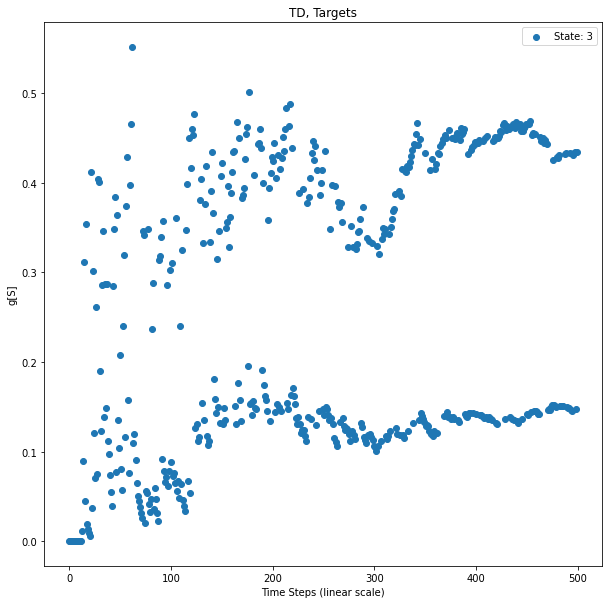

In [188]:
def targetTD():
    pi = [
      [0,0],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0.5,0.5],
      [0,0],
    ]
    rwe = gym.make('assignment_1.envs:RWE-v0', n_states = 7, prob=0.5)
    print("Testing TD")
    _,g = temporalDifferencePrediction(env=rwe, pi=pi, gamma=0.9, alpha_start=0.5, alpha_end=0.01, maxEpisodes=5*10**2, decayType='exponential')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title("TD, Targets")  
    plt.xlabel('Time Steps (linear scale)')
    plt.ylabel('g[S]')
    plt.scatter(np.arange(500), g[:,3], label=('State: 3'))
    plt.legend()
    plt.show()

targetTD()